# Country comparison — GHI / DNI / DHI

This notebook loads the three raw country files, cleans them consistently, then compares GHI, DNI and DHI across countries with boxplots, a summary table, statistical testing, and a ranking bar chart.

Files loaded: `../data/sierra_leone.csv`, `../data/benin.csv`, `../data/togo.csv`. Run cells in order.

In [24]:
# Imports
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from scipy import stats
from IPython.display import display, Markdown
print('Imports ready')

Imports ready


In [27]:
# Load and clean the three provided files — single action
paths = {
    'Sierra Leone': 'data/sierra_leone_clean.csv',
    'Benin': 'data/benin_clean.csv',
    'Togo': 'data/togo_clean.csv'
}
frames = []
missing = []
for country, p in paths.items():
    if not os.path.exists(p):
        missing.append(p)
        print(f'Missing: {p}')
        continue
    print(f'Loading {country} from {p}')
    df = pd.read_csv(p)
    # coerce numeric expected cols
    for c in ['GHI','DNI','DHI','ModA','ModB','WS','WSgust','Tamb','RH','BP']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    # parse timestamp if present
    if 'Timestamp' in df.columns:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
        df = df.sort_values('Timestamp')
    # flag outliers (z-score)
    check = [c for c in ['GHI','DNI','DHI','ModA','ModB','WS','WSgust'] if c in df.columns]
    if check:
        z = (df[check] - df[check].mean()) / df[check].std(ddof=0)
        df['outlier_z'] = z.abs().gt(3).any(axis=1)
    else:
        df['outlier_z'] = False
    # IQR flag
    out_iqr = pd.Series(False, index=df.index)
    for c in check:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        out_iqr = out_iqr | ((df[c] < (q1 - 1.5*iqr)) | (df[c] > (q3 + 1.5*iqr)))
    df['outlier_iqr'] = out_iqr
    df['outlier_flag'] = df['outlier_z'] | df['outlier_iqr']
    # impute medians for key cols
    for c in ['GHI','DNI','DHI','ModA','ModB']:
        if c in df.columns:
            df[c] = df[c].fillna(df[c].median())
    # interpolate wind if timestamp
    for c in ['WS','WSgust']:
        if c in df.columns:
            if 'Timestamp' in df.columns and not df['Timestamp'].isna().all():
                s = df[c].copy(); s.index = df['Timestamp']
                try:
                    df[c] = s.interpolate(method='time').values
                except Exception:
                    df[c] = s.interpolate().values
            df[c] = df[c].fillna(df[c].median())
    df['country'] = country
    frames.append(df)

if missing:
    print('\nWarning: missing files:')
    for m in missing:
        print(' -', m)

if not frames:
    raise FileNotFoundError('No files loaded — ensure the three CSVs exist at the given paths')

# save cleaned per-country CSVs to data/ (do not commit)
os.makedirs('data', exist_ok=True)
for df in frames:
    out = f"data/{df['country'].iloc[0].lower().replace(' ', '_')}_clean.csv"
    df.to_csv(out, index=False)
    print('Saved cleaned:', out)

# combined DF
df_all = pd.concat(frames, ignore_index=True)
print('\nCombined shape:', df_all.shape)
print('Countries:', df_all['country'].unique())

Loading Sierra Leone from data/sierra_leone_clean.csv
Loading Benin from data/benin_clean.csv
Loading Benin from data/benin_clean.csv
Loading Togo from data/togo_clean.csv
Loading Togo from data/togo_clean.csv
Saved cleaned: data/sierra_leone_clean.csv
Saved cleaned: data/sierra_leone_clean.csv
Saved cleaned: data/benin_clean.csv
Saved cleaned: data/benin_clean.csv
Saved cleaned: data/togo_clean.csv

Combined shape: (1201894, 23)
Countries: ['Sierra Leone' 'Benin' 'Togo']
Saved cleaned: data/togo_clean.csv

Combined shape: (1201894, 23)
Countries: ['Sierra Leone' 'Benin' 'Togo']


In [28]:
# Numeric summary & missing-value report for GHI,DNI,DHI
metrics = [c for c in ['GHI','DNI','DHI'] if c in df_all.columns]
print('Metrics present:', metrics)
if metrics:
    display(df_all[metrics].describe().T)
    miss = df_all[metrics].isna().sum()
    pct = (miss / len(df_all)) * 100
    print('\nMissing counts:')
    print(miss)
    print('\nColumns with >5% nulls:')
    print(pct[pct > 5])
else:
    print('No GHI/DNI/DHI columns found')

Metrics present: ['GHI', 'DNI', 'DHI']


,count,mean,std,min,25%,50%,75%,max
GHI,1201894.0,223.685115,317.370539,-19.5,-2.6,0.3,427.8,1499.0
DNI,1201894.0,152.347780,253.087966,-7.8,-0.3,0.0,255.1,1004.5
DHI,1201894.0,111.289479,154.630085,-17.9,-2.0,0.4,211.0,892.0



Missing counts:
GHI    0
DNI    0
DHI    0
dtype: int64

Columns with >5% nulls:
Series([], dtype: float64)


C:\Users\BIOS\AppData\Local\Temp\ipykernel_2680\3170106562.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y='GHI', data=df_all, palette='Set2')


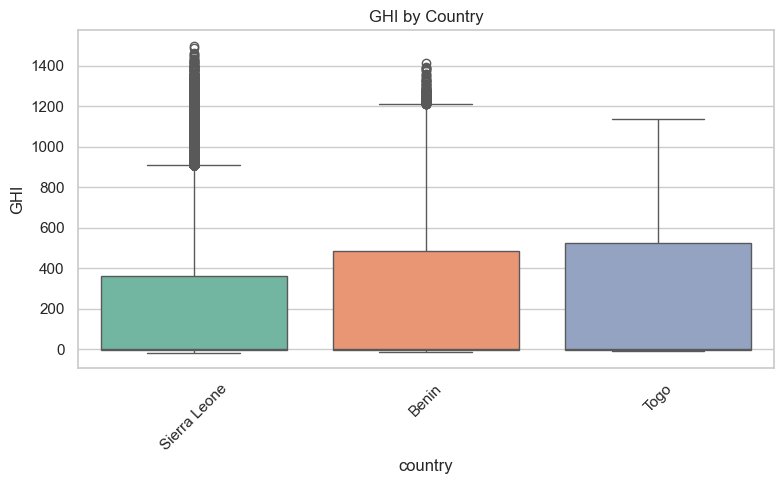

In [29]:
# Boxplot: GHI by country
if 'GHI' in df_all.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='country', y='GHI', data=df_all, palette='Set2')
    plt.title('GHI by Country')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('GHI not available')

C:\Users\BIOS\AppData\Local\Temp\ipykernel_2680\3130724793.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y='DNI', data=df_all, palette='Set3')


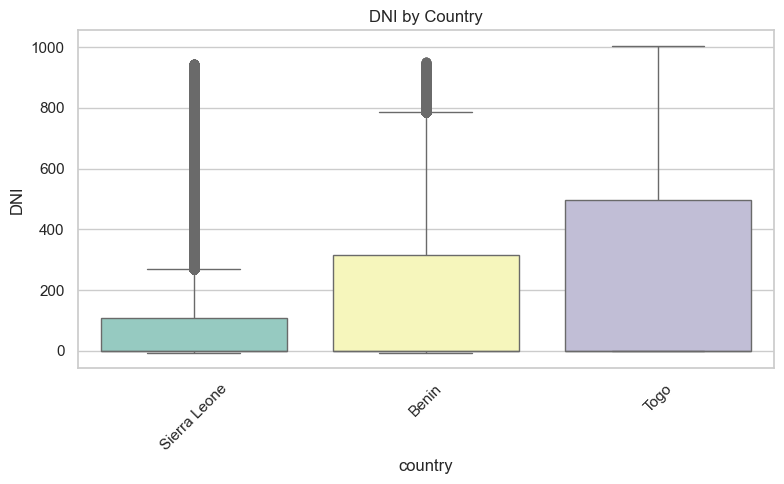

In [30]:
# Boxplot: DNI by country
if 'DNI' in df_all.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='country', y='DNI', data=df_all, palette='Set3')
    plt.title('DNI by Country')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('DNI not available')

C:\Users\BIOS\AppData\Local\Temp\ipykernel_2680\2001159503.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='country', y='DHI', data=df_all, palette='Pastel1')


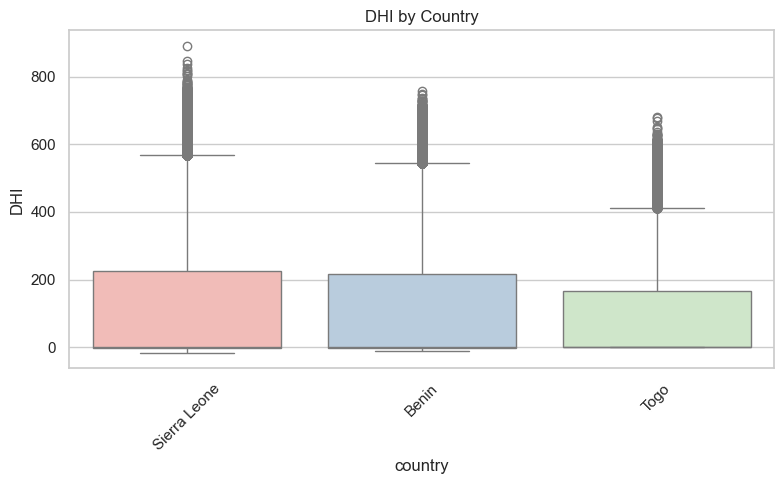

In [31]:
# Boxplot: DHI by country
if 'DHI' in df_all.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='country', y='DHI', data=df_all, palette='Pastel1')
    plt.title('DHI by Country')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('DHI not available')

In [32]:
# Summary table: mean, median, std
metrics = [c for c in ['GHI','DNI','DHI'] if c in df_all.columns]
agg = df_all.groupby('country')[metrics].agg(['mean','median','std'])
agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
agg = agg.reset_index()
display(agg)
print('\nSummary calculated')

,country,GHI_mean,GHI_median,GHI_std,DNI_mean,DNI_median,DNI_std,DHI_mean,DHI_median,DHI_std
0,Benin,240.559452,1.8,331.131327,167.187516,-0.1,261.710501,115.358961,1.6,158.691074
1,Sierra Leone,201.957515,0.3,298.495150,116.376337,-0.1,218.652659,113.720571,-0.1,158.946032
2,Togo,240.612626,-1.5,327.443429,226.052271,0.0,307.436974,88.616370,0.0,118.995617



Summary calculated


In [33]:
# Statistical test on GHI across countries
from scipy.stats import f_oneway, kruskal

groups = [g['GHI'].dropna().values for n,g in df_all.groupby('country') if len(g['GHI'].dropna())>1]
labels = [n for n,g in df_all.groupby('country') if len(g['GHI'].dropna())>1]
if len(groups) >= 2:
    try:
        fstat, p_anova = f_oneway(*groups)
        print(f'ANOVA: F={fstat:.4f}, p={p_anova:.4g}')
    except Exception as e:
        print('ANOVA failed:', e)
        p_anova = None
    try:
        kstat, p_kruskal = kruskal(*groups)
        print(f'Kruskal-Wallis: H={kstat:.4f}, p={p_kruskal:.4g}')
    except Exception as e:
        print('Kruskal-Wallis failed:', e)
        p_kruskal = None
else:
    print('Not enough groups/samples to run ANOVA/Kruskal')

ANOVA: F=2197.0034, p=0
Kruskal-Wallis: H=4042.2983, p=0


In [34]:
# Generate three short observations automatically and display as markdown
# 1) country with highest median GHI
if 'GHI' in df_all.columns:
    medians = agg[['country','GHI_median']].set_index('country')['GHI_median']
    highest_median = medians.idxmax()
    highest_median_val = medians.max()
    # 2) country with highest std
    stds = agg[['country','GHI_std']].set_index('country')['GHI_std']
    highest_std = stds.idxmax()
    highest_std_val = stds.max()
    # 3) significance
    p_text = ''
    try:
        p = p_anova if 'p_anova' in globals() and p_anova is not None else p_kruskal if 'p_kruskal' in globals() else None
        if p is not None:
            p_text = f"(p = {p:.4g})"
        else:
            p_text = '(stat test not run)'
    except Exception:
        p_text = '(stat test not available)'

    md = f"""
### Key observations

- {highest_median} has the highest median GHI ({highest_median_val:.1f}).
- {highest_std} shows the largest variability in GHI (std = {highest_std_val:.1f}).
- Differences across countries by GHI: {p_text}
"""
    display(Markdown(md))
else:
    display(Markdown('### Key observations\n\n- Not enough GHI data to compute observations.'))


### Key observations

- Benin has the highest median GHI (1.8).
- Benin shows the largest variability in GHI (std = 331.1).
- Differences across countries by GHI: (p = 0)


C:\Users\BIOS\AppData\Local\Temp\ipykernel_2680\2544057473.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg.values, y=avg.index, palette='viridis')


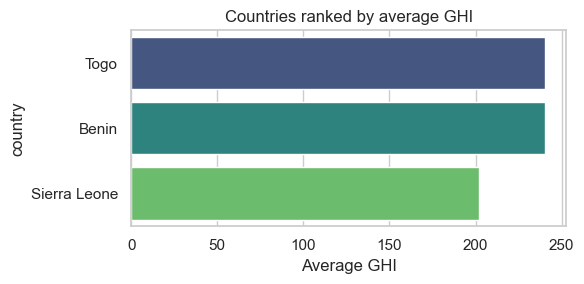

In [35]:
# Bonus: bar chart ranking countries by average GHI
if 'GHI' in df_all.columns:
    avg = df_all.groupby('country')['GHI'].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,3))
    sns.barplot(x=avg.values, y=avg.index, palette='viridis')
    plt.xlabel('Average GHI')
    plt.title('Countries ranked by average GHI')
    plt.tight_layout()
    plt.show()
else:
    print('GHI not available for ranking')